In [1]:
import torchvision
from torch.utils.data import Subset, DataLoader
import torch
import torchvision
import torch.nn.functional as F

import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import math
import tqdm
from tqdm import tqdm as tqdm
from models import *
%matplotlib inline
#from torch.utils.tensorboard import SummaryWriter
import random

In [2]:
# Load Dataset

dataset = torchvision.datasets.MNIST('./tmp', train=True, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

dataset_test = torchvision.datasets.MNIST('./tmp', train=False, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

batch_size=128

# Split the indices in a stratified way
indices = np.arange(len(dataset))

#train_indices, test_indices = train_test_split(indices, train_size=100*10, stratify=dataset.targets)

train_indices = indices[0:int(np.floor(2000/batch_size))*batch_size]
test_indices = indices[0:int(np.floor(2000/batch_size))*batch_size]

# Warp into Subsets and DataLoaders
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset_test, test_indices)

train_loader = DataLoader(train_dataset, shuffle=True, num_workers=2, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, num_workers=2, batch_size=batch_size)


In [3]:
# Functions for one forward pass for training and validation

def train_step(hidden_size, input_tensor, target):
    hidden_bottom_0 = torch.zeros(1,hidden_size).to(device)
    hidden_top_0 = torch.zeros(1,hidden_size).to(device)
    frnn.zero_grad()

    for i in range(input_tensor.shape[-1]):
    #for i in range(300):
        out, hidden_bottom_0, hidden_top_0 = frnn(input_tensor[:,i:i+1], hidden_bottom_0.to(device), hidden_top_0.to(device))
        #out, hidden_bottom_0 = frnn(input_tensor[:,i:i+1], hidden_bottom_0)
        if i==input_tensor.shape[-1]-1:
        #if i == 1:
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
            return loss.item(), out
        
        
def val_step(hidden_size, input_tensor, target):
    hidden_bottom_0 = torch.zeros(1,hidden_size).to(device)
    hidden_top_0 = torch.zeros(1,hidden_size).to(device)

    for i in range(input_tensor.shape[-1]):
        out, hidden_bottom_0, hidden_top_0 = frnn(input_tensor[:,i:i+1], hidden_bottom_0.to(device), hidden_top_0.to(device))
        if i==input_tensor.shape[-1]-1:
            loss = criterion(out, target)
            return loss.item(), out
        
def train_step_arnn(hidden_size, input_tensor, target):
    hidden_bottom_0 = torch.zeros(1,hidden_size).to(device)
    frnn.zero_grad()

    for i in range(input_tensor.shape[-1]):
        #out, hidden_bottom_0, hidden_top_0 = frnn(input_tensor[:,i:i+1], hidden_bottom_0.to(device), hidden_top_0.to(device))
        out, hidden_bottom_0 = frnn(input_tensor[:,i:i+1], hidden_bottom_0.to(device))
        if i==input_tensor.shape[-1]-1:
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
            return loss.item(), out
        
        
def train_step_lstm(hidden_size, input_tensor, target, batch_size):
    hidden_bottom_0 = torch.zeros(batch_size,hidden_size).to(device)
    c_0 = torch.zeros(batch_size,hidden_size).to(device)
    frnn.zero_grad()

    for i in range(input_tensor.shape[-1]):
        out, hidden_bottom_0, c_0 = frnn(input_tensor[:,i:i+1], hidden_bottom_0.to(device), c_0.to(device))

        if i==input_tensor.shape[-1]-1:
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
            return loss.item(), out

        
        
def val_step_arnn(hidden_size, input_tensor, target):
    hidden_bottom_0 = torch.zeros(1,hidden_size).to(device)
    for i in range(input_tensor.shape[-1]):
        out, hidden_bottom_0 = frnn(input_tensor[:,i:i+1], hidden_bottom_0.to(device))
        if i==input_tensor.shape[-1]-1:
            loss = criterion(out, target)
            return loss.item(), out
        
        
def val_step_lstm(hidden_size, input_tensor, target, batch_size):
    hidden_bottom_0 = torch.zeros(batch_size,hidden_size).to(device)
    c_0 = torch.zeros(batch_size,hidden_size).to(device)
    frnn.zero_grad()

    for i in range(input_tensor.shape[-1]):
        out, hidden_bottom_0, c_0 = frnn(input_tensor[:,i:i+1], hidden_bottom_0.to(device), c_0.to(device))

        if i==input_tensor.shape[-1]-1:
            loss = criterion(out, target)
            return loss.item(), out
        
        
        
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [4]:
class A_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, epsilon=0.1, gamma=0.15):
        super().__init__()
        
        #Input to Hidden Weight:
        ith_weights = torch.Tensor(hidden_size, input_size)
        self.ith_weights = nn.Parameter(ith_weights, requires_grad=True)
        
        #Hidden to Hidden Weight:
        hth_weights = torch.Tensor(hidden_size, hidden_size)
        self.hth_weights = nn.Parameter(hth_weights,requires_grad=True)
        
        h_bias = torch.Tensor(hidden_size)
        self.h_bias = nn.Parameter(h_bias, requires_grad=True)
        
        self.epsilon = epsilon
        self.gamma = gamma
        
        
        
        #Hidden to Output Weights:
        hto_weights = torch.Tensor(output_size, hidden_size)
        self.hto_weights = nn.Parameter(hto_weights,requires_grad=True)
        
        o_bias = torch.Tensor(output_size)
        self.o_bias = nn.Parameter(o_bias, requires_grad=True)
        
        #Init weights
        #nn.init.kaiming_uniform(self.ith_weights, a=math.sqrt(5))
        #nn.init.kaiming_uniform(self.hto_weights, a=math.sqrt(5))
        #nn.init.kaiming_uniform(self.hth_weights, a=math.sqrt(5))
        
        nn.init.normal_(self.ith_weights, mean=0, std=1);
        nn.init.normal_(self.hto_weights, mean=0, std=1/hidden_size);
        nn.init.normal_(self.hth_weights, mean=0, std=1/hidden_size);
        
        nn.init.zeros_(self.h_bias)
        nn.init.zeros_(self.o_bias)


        
        
    def forward(self, input, hidden_old):
        #Enforce antisymmetric weights
        hth = self.hth_weights - self.hth_weights.t()
        hth = hth - self.gamma * torch.eye(hidden_size, hidden_size).to(device)

        
        #Calculate bottom_layer
        hidden = torch.tanh(torch.mm(input, self.ith_weights.t())
                           +torch.mm(hidden_old, hth.t())
                           + self.h_bias)
        #Skip Connection:
        hidden = hidden_old +  self.epsilon * hidden
        

        output = F.softmax(torch.mm(hidden, self.hto_weights.t()) + self.o_bias)
        return output, hidden

In [5]:
class LSTM_NET(nn.Module):
    """
    An LSTM Wrapper with a fully connected head.
    input: torch.tensor of shape (seq_len, batch_dim, feature_dim)
    hidden: Tuple containing (hidden states, cell states)
    """
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        #self.lstm = torch.nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.lstm = torch.nn.LSTMCell(input_size=input_size, hidden_size=hidden_size)


        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden, c):
        out, cell = self.lstm(input, (hidden, c))
        output = self.fc(out)
        return output, out, cell

### Training the model 

In [160]:
# Load Dataset

dataset = torchvision.datasets.MNIST('./tmp', train=True, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

dataset_test = torchvision.datasets.MNIST('./tmp', train=False, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

batch_size=128

# Split the indices in a stratified way
indices = np.arange(len(dataset))

#train_indices, test_indices = train_test_split(indices, train_size=100*10, stratify=dataset.targets)

train_indices = indices[0:int(np.floor(2000/batch_size))*batch_size]
test_indices = indices[0:int(np.floor(2000/batch_size))*batch_size]

# Warp into Subsets and DataLoaders
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset_test, test_indices)

train_loader = DataLoader(train_dataset, shuffle=True, num_workers=2, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, num_workers=2, batch_size=batch_size)


In [161]:
epochs = 5
hidden_size = 20
gamma = 0.01
epsilon = 0.01

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [162]:
## MAIN TRAINING LOOP ## 


#frnn = FRNN_AS_SC(1,hidden_size,10, epsilon=epsilon, gamma=gamma)
#frnn = FRNN_SC(1,hidden_size,10, epsilon=epsilon, gamma=gamma)

#frnn = TLRNN_AS_SC(1,hidden_size,10, epsilon=epsilon, gamma=gamma)



frnn =A_RNN(1, hidden_size,10,epsilon=epsilon, gamma=gamma)
#frnn = LSTM_NET(1, hidden_size,10)

frnn.to(device)
#frnn = CustomRNN(1,hidden_size,10)
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(frnn.parameters(), lr=1e-4)
optimizer= torch.optim.Adagrad(frnn.parameters(), lr=1e-1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=10, verbose=True, factor=0.1)


#Lists to gather data
losses = []
accuracys = []
val_losses = []
val_accuracys = []

for epoch in range(epochs):
    epoch_accuracys = []
    epoch_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.reshape(batch_size,-1)
        data = data.to(device)
        target = target.to(device)
    
        #loss, pred = train_step(hidden_size, data, target)
        loss, pred = train_step_arnn(hidden_size, data, target)
        #loss, pred = train_step_lstm(hidden_size, data, target, batch_size)


        epoch_losses.append(loss)
        acc = get_accuracy(pred, target, batch_size)
        epoch_accuracys.append(acc)
    
    

    losses.append(np.mean(epoch_losses))
    accuracys.append(np.mean(epoch_accuracys))
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
      %(epoch, np.mean(epoch_losses) , np.mean(epoch_accuracys)))
    

    
    epoch_accuracys = []
    epoch_losses = []
    


    #Performing Evaluation
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.reshape(batch_size,-1)
        data = data.to(device)
        target = target.to(device)

        #loss, pred = val_step(hidden_size, data, target)
        loss, pred = val_step_arnn(hidden_size, data, target)
        #loss, pred = val_step_lstm(hidden_size, data, target, batch_size)


        epoch_losses.append(loss)
        acc = get_accuracy(pred, target, batch_size)
        epoch_accuracys.append(acc)
        
    #Save best model only
    if(epoch > 1):
        if(np.mean(epoch_losses) < np.min(val_losses)):
            path = "model.pt"
            torch.save(frnn.state_dict(), path)
        
    val_losses.append(np.mean(epoch_losses))
    val_accuracys.append(np.mean(epoch_accuracys))

    
    #optimizer.step(np.mean(epoch_losses))

        


    print('Epoch:  %d | Val-Loss: %.4f | Val Accuracy: %.2f' 
      %(epoch, np.mean(epoch_losses) , np.mean(epoch_accuracys)))
    

/tmp/ipykernel_7130/720636640.py:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(torch.mm(hidden, self.hto_weights.t()) + self.o_bias)


Epoch:  0 | Loss: 2.2749 | Train Accuracy: 15.89
Epoch:  0 | Val-Loss: 2.2467 | Val Accuracy: 17.03
Epoch:  1 | Loss: 2.1934 | Train Accuracy: 29.53
Epoch:  1 | Val-Loss: 2.1489 | Val Accuracy: 34.06
Epoch:  2 | Loss: 2.1174 | Train Accuracy: 37.86
Epoch:  2 | Val-Loss: 2.1203 | Val Accuracy: 35.05
Epoch:  3 | Loss: 2.0778 | Train Accuracy: 41.25
Epoch:  3 | Val-Loss: 2.0700 | Val Accuracy: 42.29
Epoch:  4 | Loss: 2.0376 | Train Accuracy: 44.90
Epoch:  4 | Val-Loss: 2.0464 | Val Accuracy: 43.70


## Calculation of Jacobian 

In [163]:
#Resetting to Batch Size 1 for evaluating jacobian

batch_size=1

# Split the indices in a stratified way
indices = np.arange(len(dataset))

#train_indices, test_indices = train_test_split(indices, train_size=100*10, stratify=dataset.targets)

train_indices = indices[0:int(np.floor(1000/batch_size))*batch_size]
test_indices = indices[0:int(np.floor(1000/batch_size))*batch_size]

# Warp into Subsets and DataLoaders
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset_test, test_indices)

train_loader = DataLoader(train_dataset, shuffle=True, num_workers=2, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, num_workers=2, batch_size=batch_size)


In [40]:
from numpy import linalg as LA


### Calculating Jacobian over Time for AFRNN and TLARNN 

In [426]:
#Select model if not using trained one

hidden_size=20
frnn =TLRNN_AS_SC(1, hidden_size,10, epsilon=0.01, gamma=0.01)
frnn = FRNN_AS_SC(1,hidden_size,10, epsilon=0.01, gamma=0.01)
#frnn = FRNN_SC(1,hidden_size,10, epsilon=0.01, gamma=0.003)


frnn.to(device)

FRNN_AS_SC()

In [427]:
# Calculating the gradients 


max_vals = []

all_grads_top_top = []
all_grads_top_bottom = []
all_grads_bottom_bottom = []
all_grads_bottom_top = []

grads_top_top = []
grads_top_bottom = []
grads_bottom_bottom = []
grads_bottom_top = []


def print_grad_top(grad):
    #frnn.zero_grad()
    #print(grad)
    if ACTIVE== "top":
        grads_top_top.append(grad.clone().detach().cpu().numpy())
    else:
        grads_bottom_top.append(grad.clone().detach().cpu().numpy())

    #max_vals.append(np.mean(np.abs(LA.eig(grad.clone().detach().cpu())[0])))
    
def print_grad_bottom(grad):
    #frnn.zero_grad()
    #print(grad)
    if ACTIVE== "top":
        grads_top_bottom.append(grad.clone().detach().cpu().numpy())
    else:
        grads_bottom_bottom.append(grad.clone().detach().cpu().numpy())

i = 2

for batch_idx, (data, target) in enumerate(train_loader):
    data = data.reshape(batch_size,-1)
    data = data.to(device)
    target = target.to(device)
    if(batch_idx == i):
        break
    
input_tensor = data
criterion = nn.CrossEntropyLoss()


    
hidden_bottom_0 = torch.zeros(1,hidden_size).to(device)
hidden_top_0 = torch.zeros(1,hidden_size).to(device)
frnn.zero_grad()

T = input_tensor.shape[-1]

T=800
#for i in range(input_tensor.shape[-1]):
for i in range(T):

    #out, hidden_bottom_0, hidden_top_0 = frnn(input_tensor[:,i:i+1], hidden_bottom_0.to(device), hidden_top_0.to(device))
    out, hidden_bottom_0, hidden_top_0 = frnn(torch.rand(1,1).to(device), hidden_bottom_0.to(device), hidden_top_0.to(device))

    if(i ==0):
        
        first_zero = hidden_bottom_0

    
    hidden_bottom_0.register_hook(print_grad_bottom)
    hidden_top_0.register_hook(print_grad_top)



    #if i==input_tensor.shape[-1]-1:
    if i==T-1:

    #if i == 1:
        print("L")
        loss = criterion(out, target)
        for k in range(len(hidden_top_0[0])):
            print(k)
            
            #Calculating gradients of top layer wrt to top and bottom layer
            frnn.zero_grad()
            ACTIVE = "top"
            hidden_top_0[0][k].backward(retain_graph=True)
            all_grads_top_top.append(grads_top_top)
            all_grads_top_bottom.append(grads_top_bottom)
            grads_top_top = []
            grads_top_bottom = []
            
            #Calculating gradients of bottom layer wrt to top and bottom layer
            frnn.zero_grad()
            ACTIVE = "bottom"
            hidden_bottom_0[0][k].backward(retain_graph=True)
            all_grads_bottom_bottom.append(grads_bottom_bottom)
            all_grads_bottom_top.append(grads_bottom_top)
            grads_bottom_bottom = []
            grads_bottom_top = []

        grad = torch.ones_like(out)
        


/tmp/ipykernel_7130/3058658391.py:109: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(torch.mm(hidden2, self.hto_weights.t()) + self.o_bias)


L
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [428]:
# Rearranging the gradients to get Jacobian Matrices
jacobs_top_top = [[] for i in range(T-1)]
jacobs_top_bottom = [[] for i in range(T-1)]
jacobs_bottom_bottom = [[] for i in range(T-1)]
jacobs_bottom_top = [[] for i in range(T-1)]


        
for i in range(0, len(all_grads_top_top)):
    for j in range(1, len(jacobs_bottom_bottom)):
        jacobs_top_top[j].append(all_grads_top_top[i][j])
        

for i in range(0, len(all_grads_top_bottom)):
    for j in range(1, len(jacobs_bottom_bottom)):
        jacobs_top_bottom[j].append(all_grads_top_bottom[i][j])
        
for i in range(0, len(all_grads_bottom_bottom)):
    for j in range(1, len(jacobs_bottom_bottom)):
        jacobs_bottom_bottom[j].append(all_grads_bottom_bottom[i][j])
        
for i in range(0, len(all_grads_top_top)):
    for j in range(1, len(jacobs_bottom_bottom)):
        if all_grads_bottom_top[i] == []:
            jacobs_bottom_top[j].append(np.zeros_like(all_grads_bottom_bottom[i][j]))
        else:
            jacobs_bottom_top[j].append(all_grads_bottom_top[i][j])
            
            
jacobs_final = []
for i in range(1, len(jacobs_top_top)):
    
    #J = np.concatenate(jacobs_top_top[i])
    #J = np.concatenate((J, np.concatenate(jacobs_top_bottom[i])))
    #J2 = np.concatenate(jacobs_bottom_top[i])
    #J2 = np.concatenate((J2, np.concatenate(jacobs_bottom_bottom[i])))
    #J = np.concatenate((J, J2), axis=1)
    
    
    J = np.concatenate(jacobs_top_top[i])
    jacobs_final.append(J)
    
jacobs_EVs = []
for jacob in jacobs_final:
    #jacobs_EVs.append(np.mean(np.abs(LA.eig(jacob)[0])))
    jacobs_EVs.append(np.max(np.abs(LA.eig(jacob)[0])))

        
####
        
# for neuron_grads in all_grads_top_bottom:
#     for j in range(1, len(jacobs_bottom_bottom)):
#         print(j)
#         print(neuron_grads)
#         jacobs_top_bottom[j].append(neuron_grads[j])
        
# for neuron_grads in all_grads_bottom_bottom:
#     for j in range(1, len(jacobs_bottom_bottom)):
#         jacobs_bottom_bottom[j].append(neuron_grads[j])
        
# for neuron_grads in all_grads_bottom_top:
#     for j in range(1, len(jacobs_bottom_bottom)):
#         jacobs_bottom_top[j].append(neuron_grads[j])

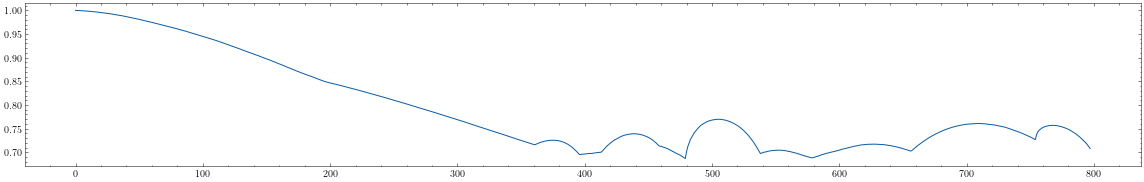

In [429]:
plt.plot(jacobs_EVs)


In [317]:
#JACOBS_AFRNN1 = jacobs_EVs

In [327]:
#JACOBS_FNN = jacobs_EVs

In [332]:
#JACOBS_TLRNN = jacobs_EVs

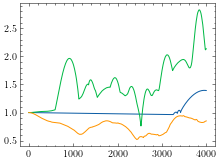

In [333]:
plt.plot(JACOBS_TLRNN)
plt.plot(JACOBS_FNN)
plt.plot(JACOBS_AFRNN1)
#plt.plot(JACOBS_ARNN1)

### Calculating Jacobian over Time for ARNN

In [349]:
hidden_size=4
frnn = A_RNN(1, hidden_size,10, epsilon=0.01, gamma=0.003)
#frnn = LSTM_NET(1, hidden_size,10)

frnn.to(device)


A_RNN()

In [353]:

max_vals = []

all_grads = []
grads = []

def print_grad(grad):

    grads.append(grad.clone().detach().cpu().numpy())

i = 2

for batch_idx, (data, target) in enumerate(train_loader):
    data = data.reshape(batch_size,-1)
    data = data.to(device)
    target = target.to(device)
    if(batch_idx == i):
        break
    
input_tensor = data
criterion = nn.CrossEntropyLoss()


    
hidden_bottom_0 = torch.zeros(1,hidden_size).to(device)
hidden_top_0 = torch.zeros(1,hidden_size).to(device)
frnn.zero_grad()

T = input_tensor.shape[-1]
T=4000

for i in range(T):
    #frnn.zero_grad()
#for i in range(300):
    #out, hidden_bottom_0 = frnn(input_tensor[:,i:i+1], hidden_bottom_0.to(device))
    out, hidden_bottom_0 = frnn(torch.rand(1,1), hidden_bottom_0.to(device))



        
    #hd = hidden_top_0.clone()
    hidden_bottom_0.register_hook(print_grad)


    if i==T-1:
    #if i == 1:
        print("L")
        loss = criterion(out, target)

        for k in range(len(hidden_top_0[0])):
            print(k)
            frnn.zero_grad()
            hidden_bottom_0[0][k].backward(retain_graph=True)
            all_grads.append(grads)
            grads = []

        grad = torch.ones_like(out)



/tmp/ipykernel_7130/720636640.py:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(torch.mm(hidden, self.hto_weights.t()) + self.o_bias)


L
0
1
2
3


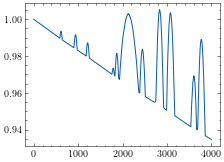

In [354]:
len(all_grads)
jacobs = [[] for i in range(T-1)]

for neuron_grads in all_grads:
    for j in range(len(jacobs)):
        jacobs[j].append(neuron_grads[j])
jacobs_final = []
for jacob in jacobs:
    jacobs_final.append(np.concatenate(jacob))
jacobs_EVs = []
for jacob in jacobs_final:
    jacobs_EVs.append(np.mean(np.abs(LA.eig(jacob)[0])))
#plt.ylim((0,1))
plt.plot(jacobs_EVs)

In [355]:
jacobs_final[0].shape

(4, 4)

In [356]:
JACOBS_ARNN1 = jacobs_EVs

### Calculating Jacobian over Time for LSTM

In [342]:
frnn = LSTM_NET(1, hidden_size,10)

frnn.to(device)

LSTM_NET(
  (lstm): LSTMCell(1, 4)
  (fc): Linear(in_features=4, out_features=10, bias=True)
)

In [235]:
device = 'cpu'

In [344]:

max_vals = []

all_grads = []
grads = []

def print_grad(grad):
    #frnn.zero_grad()
    #print(grad)
    grads.append(grad.clone().detach().cpu().numpy())
    #max_vals.append(np.mean(np.abs(LA.eig(grad.clone().detach().cpu())[0])))

i = 2

for batch_idx, (data, target) in enumerate(train_loader):
    data = data.reshape(batch_size,-1)
    data = data.to(device)
    target = target.to(device)
    if(batch_idx == i):
        break
    
input_tensor = data
criterion = nn.CrossEntropyLoss()


    
hidden_bottom_0 = torch.zeros(1,hidden_size).to(device)
c_0 = torch.zeros(1,hidden_size).to(device)
frnn.zero_grad()

T = input_tensor.shape[-1]
T=4000

for i in range(T):
    #frnn.zero_grad()
#for i in range(300):
    #out, hidden_bottom_0, c_0 = frnn(input_tensor[:,i:i+1], hidden_bottom_0.to(device), c_0.to(device))
    out, hidden_bottom_0, c_0 = frnn(torch.rand(1,1), hidden_bottom_0.to(device), c_0.to(device))


        
    #hd = hidden_top_0.clone()
    hidden_bottom_0.register_hook(print_grad)


    if i==input_tensor.shape[-1]-1:
    #if i == 1:
        print("L")
        loss = criterion(out, target)

        for k in range(len(hidden_bottom_0[0])):
            print(k)
            frnn.zero_grad()
            hidden_bottom_0[0][k].backward(retain_graph=True)
            all_grads.append(grads)
            grads = []

        grad = torch.ones_like(out)
        
        #torch.autograd.backward([out], [grad])
        
#         for i in range(len(hidden_top_0[0])):
#             print(i)
#             hidden_top_0[0][i].backward(retain_graph=True)
        

        #optimizer.step()


L
0
1
2
3


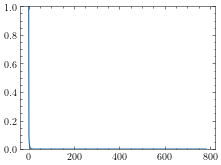

In [345]:
len(all_grads)
jacobs = [[] for i in range(input_tensor.shape[-1])]

for neuron_grads in all_grads:
    for j in range(len(jacobs)):
        jacobs[j].append(neuron_grads[j])
jacobs_final = []
for jacob in jacobs:
    jacobs_final.append(np.concatenate(jacob))
jacobs_EVs = []
for jacob in jacobs_final:
    jacobs_EVs.append(np.mean(np.abs(LA.eig(jacob)[0])))
plt.ylim((0,1))

plt.plot(jacobs_EVs)

In [346]:
LSTM_TRAINED = jacobs_EVs

In [239]:
plt.style.use('science')


In [376]:
LSTM_TRAINED = np.load("jacobian_gamma_001/lstm.npy")
JACOBS_AFRNN1 = np.load("jacobian_gamma_001/afrnn.npy")
JACOBS_ARNN1 = np.load("jacobian_gamma_001/arnn.npy")
JACOBS_TLRNN = np.load("jacobian_gamma_001/2arnn.npy")
JACOBS_FNN = np.load("jacobian_gamma_001/frnn.npy")

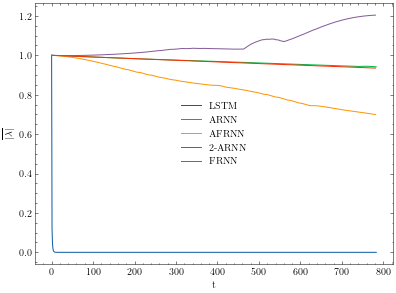

In [394]:
#plt.yscale('log')
plt.plot(LSTM_TRAINED, label='LSTM')
#plt.rcParams["figure.figsize"] = (20,3)
#plt.plot(JACOBS_ARNN, label='ARNN')
plt.plot(JACOBS_ARNN1, label='ARNN')
#plt.plot(JACOBS_AFRNN, label='AFRNN')
plt.plot(JACOBS_AFRNN1, label='AFRNN')
#plt.plot(JACOBS_TLRNN1, label='TLRNN')
plt.plot(JACOBS_TLRNN, label='2-ARNN')
plt.plot(JACOBS_FNN, label='FRNN')
plt.xlabel("t")
plt.ylabel("$\overline{|\lambda|}$")
plt.legend()
plt.savefig('jacobian_trained.pdf')

In [250]:
import json

In [256]:
np.save("lstm.npy", LSTM_TRAINED)
np.save("afrnn.npy", JACOBS_AFRNN1)
np.save("arnn.npy", JACOBS_ARNN1)
np.save("2arnn.npy", JACOBS_TLRNN)
np.save("frnn.npy", JACOBS_FNN)